# EE4331 Machine Learning Final Project:
## Using EEG Signals to Determine Neurological Disorders with Machine Learning

### David Sharp     eor13
### Fall 2024

## 0. Imports

In [1]:
import mne
from mne.preprocessing import ICA, create_eog_epochs
from mne.io import read_raw_eeglab
from mne import create_info
from mne.io import RawArray
from scipy.signal import resample
from scipy.signal import butter, sosfilt
from scipy.stats import iqr
from scipy.signal import butter, sosfiltfilt
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob
import random
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight



## 1. Participant Metadata

In [2]:
# Load the TSV file into a DataFrame
file_path = "C:/Users/dshar/OneDrive/Documents/School/EE4331 Machine Learning/Final Project/Dataset/participants.tsv"
patient_df = pd.read_csv(file_path, sep='\t')

patient_df = patient_df.rename(columns={'participant_id': 'SubjectID'})

# View the first few rows to understand the structure
print(patient_df.head())

  SubjectID Gender  Age Group  MMSE
0   sub-001      F   57     A    16
1   sub-002      F   78     A    22
2   sub-003      M   70     A    14
3   sub-004      F   67     A    20
4   sub-005      M   70     A    22


In [3]:
# Group by the 'Category' column and calculate the mean of other columns
group_means = patient_df.groupby('Group').mean(numeric_only=True)

# Display the results
print(group_means)

             Age       MMSE
Group                      
A      66.388889  17.750000
C      67.896552  30.000000
F      63.652174  22.173913


In [4]:
group_counts = patient_df['Group'].value_counts()
print(group_counts)

Group
A    36
C    29
F    23
Name: count, dtype: int64


In [5]:
gender_counts = patient_df.groupby(['Group', 'Gender']).size().reset_index(name='count')

print("Count of each gender per category:")
print(gender_counts)

Count of each gender per category:
  Group Gender  count
0     A      F     24
1     A      M     12
2     C      F     11
3     C      M     18
4     F      F      9
5     F      M     14


## Metadata Discussion

From the cells above, it can be seen that there are 88 total patients that have participated in the EEG exam for this study. There are 44 males and 44 females. There are 36 Alzheimer's patients, 29 control patients, and 23 frontotemporal dementia patients. Each EEG reading has 19 channels (electrodes) with a sampling frequency of 500 Hz.

**Alzheimer's:**
* 24 Female / 12Male
* Average Age: 66.4 Years
* Average MMSE: 17.75

**Frontotemporal Dementia:**
* 9 Female / 14 Male
* Average Age: 63.4 Years
* Average MMSE: 22.17

**Control:**
* 11 Female / 18 Male
* Average Age: 67.9 Years
* Average MMSE: 30


## 2. Load EEG Datasets and Preprocessing

### 2.a Plot Raw EEG File

Using matplotlib as 2D backend.


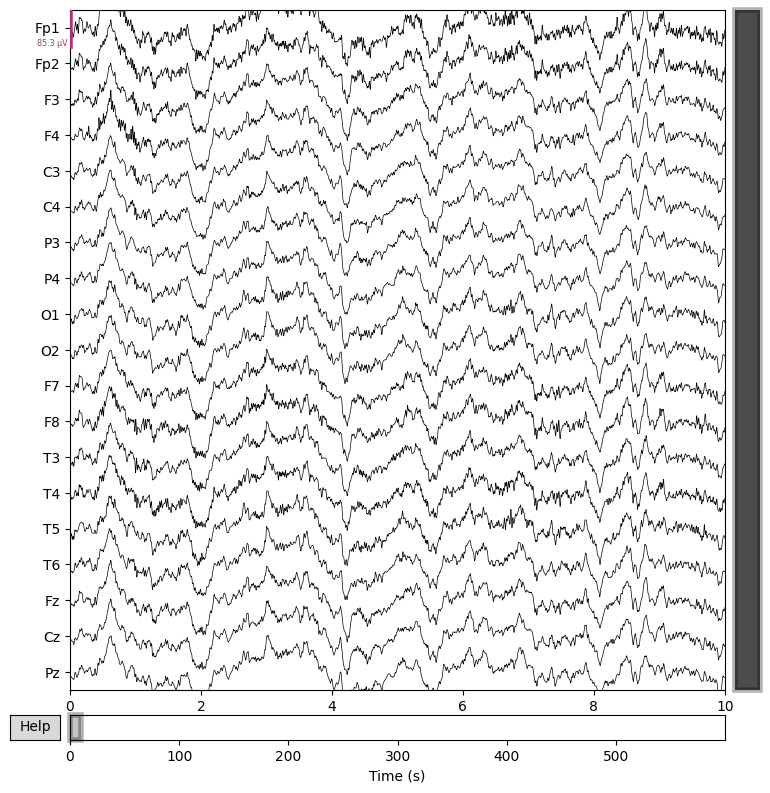

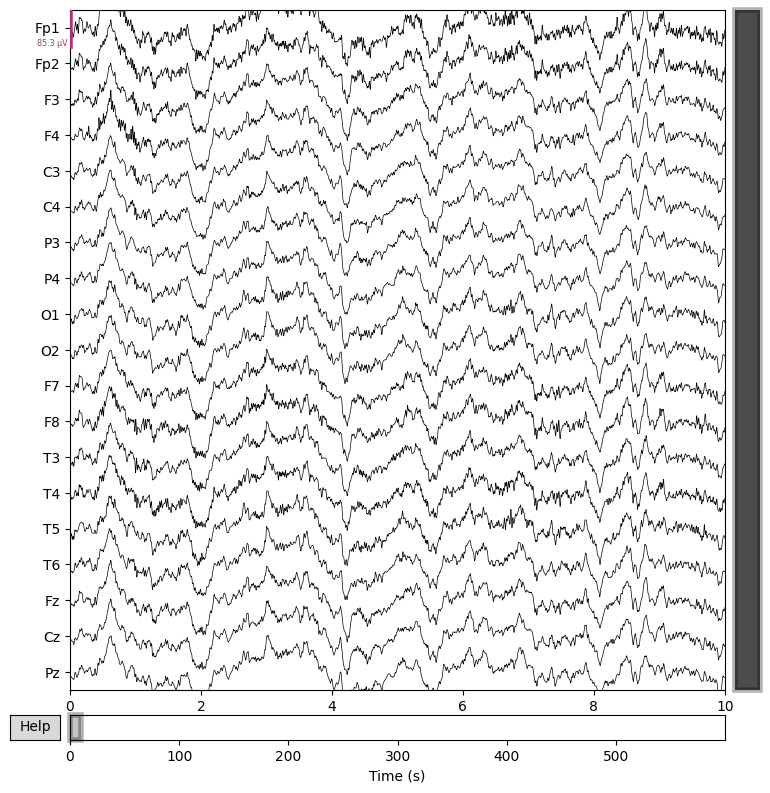

In [6]:
# Path to the patient's .set file
patient_file = 'C:/Users/dshar/OneDrive/Documents/School/EE4331 Machine Learning/Final Project/Dataset/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set'

# Load the EEG data using MNE
raw = read_raw_eeglab(patient_file, preload=True)

# Plot the raw EEG data
raw.plot(n_channels=19, duration=10, scalings='auto', title='Raw EEG Data for Single Patient', show=True)

### 2.b Read all EEGs into dataframe

In [7]:
# Define the path to the directory containing the EEG data
main_dir = Path("C:/Users/dshar/OneDrive/Documents/School/EE4331 Machine Learning/Final Project/Dataset/derivatives/")  # Replace with your directory path

# Initialize an empty list to store each patient's data
data_list = []

# Search through subdirectories to load all .set files
file_paths = glob.glob(str(main_dir / 'sub-**' / 'eeg' / '*.set'), recursive = True)

for file_path in file_paths:
    
    # Load the EEG data file
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    
    # Extract data and channel names
    data, times = raw.get_data(return_times=True)
    channel_names = raw.ch_names
    
    # Create a DataFrame for this patient
    df = pd.DataFrame(data.T, columns=channel_names)
    df['Time'] = times  # Add a time column
    
    # Add patient ID from filename or folder structure
    subject_id = Path(file_path).stem
    df['SubjectID'] = subject_id
    
    # Append to the list
    data_list.append(df)

# Concatenate all dataframes
eeg_df = pd.concat(data_list, ignore_index=True)

# Display dataframe shape
print(f"DataFrame shape: {eeg_df.shape}")

# Display the final DataFrame
print(eeg_df.head())
print(eeg_df.tail())

# Extract just the subject ID (e.g., 'sub-001', 'sub-002')
eeg_df['SubjectID_clean'] = eeg_df['SubjectID'].str.split('_').str[0]

C:\Users\dshar\AppData\Local\Temp\ipykernel_63104\314980826.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\dshar\AppData\Local\Temp\ipykernel_63104\314980826.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\dshar\AppData\Local\Temp\ipykernel_63104\314980826.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\dshar\AppData\Local\Temp\ipykernel_63104\314980826.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching aroun

DataFrame shape: (34915560, 21)
        Fp1       Fp2        F3        F4        C3        C4        P3  \
0 -0.000034 -0.000025 -0.000011 -0.000015 -0.000015 -0.000018 -0.000013   
1 -0.000028 -0.000021 -0.000011 -0.000013 -0.000014 -0.000016 -0.000012   
2 -0.000023 -0.000017 -0.000012 -0.000012 -0.000013 -0.000014 -0.000011   
3 -0.000018 -0.000013 -0.000013 -0.000010 -0.000013 -0.000012 -0.000011   
4 -0.000015 -0.000011 -0.000014 -0.000009 -0.000013 -0.000011 -0.000011   

         P4        O1        O2  ...        F8        T3        T4        T5  \
0 -0.000015 -0.000014 -0.000015  ... -0.000017 -0.000016 -0.000016 -0.000012   
1 -0.000014 -0.000015 -0.000013  ... -0.000014 -0.000015 -0.000014 -0.000014   
2 -0.000012 -0.000016 -0.000013  ... -0.000011 -0.000015 -0.000013 -0.000015   
3 -0.000011 -0.000016 -0.000012  ... -0.000009 -0.000015 -0.000013 -0.000017   
4 -0.000011 -0.000017 -0.000012  ... -0.000008 -0.000014 -0.000013 -0.000018   

         T6        Fz        Cz     

### 2.c Select number of participants to use per group

In [8]:
# Choose seed for repeatability
random.seed(42)

# Define the ranges of subjects for each group
group_A_subjects = [f'sub-{i:03}' for i in range(1, 37)]  # Subjects 1-36
group_C_subjects = [f'sub-{i:03}' for i in range(37, 66)]  # Subjects 37-65
group_F_subjects = [f'sub-{i:03}' for i in range(66, 89)]  # Subjects 66-88

# Randomly sample a specific number of subjects from each group (e.g., 10 subjects per group)
num_subjects_per_group = 5
selected_A_subjects = random.sample(group_A_subjects, num_subjects_per_group)
selected_C_subjects = random.sample(group_C_subjects, num_subjects_per_group)
selected_F_subjects = random.sample(group_F_subjects, num_subjects_per_group)

# Combine the selected subjects from all groups
selected_subjects = selected_A_subjects + selected_C_subjects + selected_F_subjects

# Filter the eeg_df_filtered dataframe to only include the selected subjects
balanced_subset = eeg_df[eeg_df['SubjectID_clean'].isin(selected_subjects)]

# Print the subset to confirm
#print(balanced_subset.head())
#print(balanced_subset.tail())

print("Selected Subjects: ", selected_subjects)

Selected Subjects:  ['sub-008', 'sub-002', 'sub-018', 'sub-016', 'sub-015', 'sub-041', 'sub-060', 'sub-040', 'sub-058', 'sub-065', 'sub-083', 'sub-068', 'sub-084', 'sub-079', 'sub-067']


### 2.d Resample data at lower freqeuncy

In [9]:
# Define target sampling rate
target_sampling_rate = 125  # Hz

# Extract unique subjects
unique_subjects = balanced_subset['SubjectID'].unique()

# Store resampled data
resampled_data_list = []

# Loop through each subject
for subject in unique_subjects:
    # Subset data for the subject
    subject_data = balanced_subset[balanced_subset['SubjectID'] == subject].copy()
    
    # Extract channel data and sampling frequency
    data = subject_data.iloc[:, :-2].to_numpy().T  # Exclude 'Time' and 'SubjectID'
    original_sampling_rate = 500  # Replace with your dataset's original rate
    
    # Resample data
    num_samples = int((len(subject_data) / original_sampling_rate) * target_sampling_rate)
    resampled_data = resample(data, num_samples, axis=1)
    
    # Create a new time array for the resampled data
    new_times = np.linspace(0, subject_data['Time'].iloc[-1], num_samples)
    
    # Convert resampled data back to DataFrame
    resampled_df = pd.DataFrame(resampled_data.T, columns=subject_data.columns[:-2])
    resampled_df['Time'] = new_times
    resampled_df['SubjectID'] = subject
    
    # Append to list
    resampled_data_list.append(resampled_df)

# Concatenate all resampled data
eeg_df_resampled = pd.concat(resampled_data_list, ignore_index=True)

# Display results
print(f"Resampled DataFrame shape: {eeg_df_resampled.shape}")
print(eeg_df_resampled.head())
print(eeg_df_resampled.tail())

Resampled DataFrame shape: (1518085, 21)
        Fp1       Fp2            F3        F4        C3        C4        P3  \
0 -0.000010 -0.000009 -1.088844e-05 -0.000010 -0.000011 -0.000011 -0.000010   
1 -0.000009 -0.000014 -1.039432e-05 -0.000008 -0.000013 -0.000012 -0.000016   
2 -0.000005 -0.000021 -1.023942e-05 -0.000001 -0.000016 -0.000011 -0.000020   
3  0.000004 -0.000013 -2.292427e-06 -0.000001 -0.000009 -0.000006 -0.000010   
4  0.000002 -0.000006 -7.975180e-07 -0.000007 -0.000002 -0.000004 -0.000005   

         P4        O1        O2  ...        F8        T3        T4        T5  \
0 -0.000009 -0.000008 -0.000012  ... -0.000006 -0.000007 -0.000004 -0.000007   
1 -0.000011 -0.000013 -0.000017  ... -0.000014 -0.000015 -0.000012 -0.000014   
2 -0.000013 -0.000019 -0.000020  ... -0.000018 -0.000023 -0.000019 -0.000020   
3 -0.000004 -0.000010 -0.000013  ... -0.000009 -0.000010 -0.000010 -0.000010   
4 -0.000003 -0.000007 -0.000011  ... -0.000005 -0.000006 -0.000011 -0.000006   

   

### 2.e Filter all signals (Butterworth Bandpass 0.5Hz-48Hz)

In [10]:
# Define Butterworth filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Creates a Butterworth bandpass filter."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band', output='sos')

def apply_filter(data, lowcut=0.5, highcut=48, fs=250, order=5):
    """Applies the Butterworth bandpass filter."""
    sos = butter_bandpass(lowcut, highcut, fs, order)
    return sosfilt(sos, data, axis=0)

# Apply filter to each subject's data
filtered_data_list = []

for subject in eeg_df_resampled['SubjectID'].unique():
    # Select data for the subject
    subject_data = eeg_df_resampled[eeg_df_resampled['SubjectID'] == subject].copy()
    
    # Apply filter to EEG channels (all columns except 'Time' and 'SubjectID')
    eeg_channels = subject_data.columns[:-2]  # Assuming last two columns are 'Time' and 'SubjectID'
    subject_data[eeg_channels] = apply_filter(subject_data[eeg_channels].to_numpy(), fs=target_sampling_rate)
    
    # Append filtered data
    filtered_data_list.append(subject_data)

# Concatenate all filtered data
eeg_df_filtered = pd.concat(filtered_data_list, ignore_index=True)

# Display results
print(f"Filtered DataFrame shape: {eeg_df_filtered.shape}")
print(eeg_df_filtered.head())
print(eeg_df_filtered.tail())


Filtered DataFrame shape: (1518085, 21)
            Fp1       Fp2            F3            F4        C3        C4  \
0 -2.842923e-06 -0.000002 -3.096580e-06 -2.780935e-06 -0.000003 -0.000003   
1 -8.923234e-06 -0.000010 -9.987967e-06 -8.514915e-06 -0.000011 -0.000010   
2 -8.143505e-06 -0.000016 -1.076443e-05 -6.434787e-06 -0.000014 -0.000012   
3  5.350485e-07 -0.000016 -4.211079e-06  1.625478e-06 -0.000010 -0.000006   
4  4.918008e-06 -0.000008  4.469195e-07 -6.991561e-07 -0.000004 -0.000002   

         P3        P4        O1        O2  ...        F8        T3        T4  \
0 -0.000003 -0.000002 -0.000002 -0.000003  ... -0.000002 -0.000002 -0.000001   
1 -0.000011 -0.000009 -0.000009 -0.000012  ... -0.000008 -0.000009 -0.000006   
2 -0.000017 -0.000012 -0.000014 -0.000018  ... -0.000015 -0.000017 -0.000014   
3 -0.000014 -0.000007 -0.000013 -0.000014  ... -0.000013 -0.000017 -0.000015   
4 -0.000005 -0.000001 -0.000006 -0.000008  ... -0.000004 -0.000006 -0.000007   

         T5     

### 2.f Plot Filtered vs Unfiltered data

In [11]:
def extract_epochs(data, epoch_length=2, overlap=1, sampling_rate=125):
    """
    Extract overlapping epochs from EEG data.

    Parameters:
    - data: DataFrame containing EEG data.
    - epoch_length: Length of each epoch in seconds (default: 5).
    - overlap: Overlap between epochs in seconds (default: 2.5).
    - sampling_rate: Sampling rate of the data in Hz (default: 250).

    Returns:
    - A list of DataFrames, each containing epochs for a single subject.
    """
    epochs_list = []
    samples_per_epoch = int(epoch_length * sampling_rate)
    overlap_samples = int(overlap * sampling_rate)
    
    for subject in data['SubjectID'].unique():
        subject_data = data[data['SubjectID'] == subject].reset_index(drop=True)
        channels = subject_data.columns[:-2]  # Exclude 'Time' and 'SubjectID'
        time = subject_data['Time']
        
        # Sliding window to extract epochs
        for start_idx in range(0, len(subject_data) - samples_per_epoch + 1, samples_per_epoch - overlap_samples):
            end_idx = start_idx + samples_per_epoch
            epoch = subject_data.iloc[start_idx:end_idx].copy()
            epoch['EpochID'] = f"{subject}_epoch_{start_idx // (samples_per_epoch - overlap_samples)}"
            epochs_list.append(epoch)
    
    return pd.concat(epochs_list, ignore_index=True)

# Apply epoch extraction
eeg_epochs = extract_epochs(eeg_df_filtered)

# Display results
print(f"Total number of epochs: {len(eeg_epochs['EpochID'].unique())}")
print(eeg_epochs.head())
print(eeg_epochs.tail())

Total number of epochs: 12125
            Fp1       Fp2            F3            F4        C3        C4  \
0 -2.842923e-06 -0.000002 -3.096580e-06 -2.780935e-06 -0.000003 -0.000003   
1 -8.923234e-06 -0.000010 -9.987967e-06 -8.514915e-06 -0.000011 -0.000010   
2 -8.143505e-06 -0.000016 -1.076443e-05 -6.434787e-06 -0.000014 -0.000012   
3  5.350485e-07 -0.000016 -4.211079e-06  1.625478e-06 -0.000010 -0.000006   
4  4.918008e-06 -0.000008  4.469195e-07 -6.991561e-07 -0.000004 -0.000002   

         P3        P4        O1        O2  ...        T3        T4        T5  \
0 -0.000003 -0.000002 -0.000002 -0.000003  ... -0.000002 -0.000001 -0.000002   
1 -0.000011 -0.000009 -0.000009 -0.000012  ... -0.000009 -0.000006 -0.000009   
2 -0.000017 -0.000012 -0.000014 -0.000018  ... -0.000017 -0.000014 -0.000015   
3 -0.000014 -0.000007 -0.000013 -0.000014  ... -0.000017 -0.000015 -0.000014   
4 -0.000005 -0.000001 -0.000006 -0.000008  ... -0.000006 -0.000007 -0.000005   

             T6        Fz 

## 3. Prepare for Modeling

### 3.a Merge features with groups

In [12]:
# Define group ranges
group_A_subjects = [f'sub-{i:03}' for i in range(1, 37)]  # Subjects 1-36
group_C_subjects = [f'sub-{i:03}' for i in range(37, 66)]  # Subjects 37-65
group_F_subjects = [f'sub-{i:03}' for i in range(66, 89)]  # Subjects 66-88

# Map subjects to groups
subject_to_group = {sub: 'A' for sub in group_A_subjects}
subject_to_group.update({sub: 'C' for sub in group_C_subjects})
subject_to_group.update({sub: 'F' for sub in group_F_subjects})

# Extract clean SubjectID from eeg_epochs
eeg_epochs['SubjectID_clean'] = eeg_epochs['SubjectID'].str.extract(r'(sub-\d{3})')

# Map the group to each SubjectID
eeg_epochs['Group'] = eeg_epochs['SubjectID_clean'].map(subject_to_group)

# Verify the mapping
print(eeg_epochs[['SubjectID', 'SubjectID_clean', 'Group']].head())

print(eeg_epochs.head())
print(eeg_epochs.tail())

                     SubjectID SubjectID_clean Group
0  sub-002_task-eyesclosed_eeg         sub-002     A
1  sub-002_task-eyesclosed_eeg         sub-002     A
2  sub-002_task-eyesclosed_eeg         sub-002     A
3  sub-002_task-eyesclosed_eeg         sub-002     A
4  sub-002_task-eyesclosed_eeg         sub-002     A
            Fp1       Fp2            F3            F4        C3        C4  \
0 -2.842923e-06 -0.000002 -3.096580e-06 -2.780935e-06 -0.000003 -0.000003   
1 -8.923234e-06 -0.000010 -9.987967e-06 -8.514915e-06 -0.000011 -0.000010   
2 -8.143505e-06 -0.000016 -1.076443e-05 -6.434787e-06 -0.000014 -0.000012   
3  5.350485e-07 -0.000016 -4.211079e-06  1.625478e-06 -0.000010 -0.000006   
4  4.918008e-06 -0.000008  4.469195e-07 -6.991561e-07 -0.000004 -0.000002   

         P3        P4        O1        O2  ...        T5            T6  \
0 -0.000003 -0.000002 -0.000002 -0.000003  ... -0.000002 -9.699692e-07   
1 -0.000011 -0.000009 -0.000009 -0.000012  ... -0.000009 -4.326920e-06 

### 3.b Sort and scale epochs

In [13]:
# Ensure the data is sorted by Time within each SubjectID
eeg_epochs = eeg_epochs.sort_values(by=['SubjectID', 'Time'])

# Group data by SubjectID
grouped_data = eeg_epochs.groupby('SubjectID')

# Prepare for storing scaled data
scaled_data = []

# Apply scaling for each subject group
for name, group in grouped_data:
    # Initialize scaler
    scaler = StandardScaler()
    
    # Extract EEG channels for scaling
    eeg_features = group[['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
                          'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']].values  
    
    # Scale the features
    scaled_features = scaler.fit_transform(eeg_features)
    
    # Replace original features with scaled ones
    group[['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
           'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']] = scaled_features
    
    # Append to scaled data
    scaled_data.append(group)

# Combine all scaled groups back into one DataFrame
eeg_epochs = pd.concat(scaled_data)

print(eeg_epochs.head())

        Fp1       Fp2        F3        F4        C3        C4        P3  \
0 -0.113022 -0.096708 -0.123661 -0.110493 -0.123933 -0.122296 -0.106478   
1 -0.355104 -0.378786 -0.399300 -0.338747 -0.426791 -0.412035 -0.417847   
2 -0.324060 -0.634227 -0.430357 -0.255943 -0.563451 -0.471209 -0.663039   
3  0.021469 -0.617621 -0.168238  0.064913 -0.420439 -0.228284 -0.546986   
4  0.195973 -0.302733  0.018071 -0.027624 -0.166509 -0.090009 -0.189765   

         P4        O1        O2  ...        T5        T6        Fz        Cz  \
0 -0.098213 -0.085354 -0.126557  ... -0.079886 -0.037068 -0.135530 -0.140894   
1 -0.349637 -0.333595 -0.470593  ... -0.328995 -0.166067 -0.445486 -0.459736   
2 -0.467981 -0.551162 -0.684950  ... -0.578706 -0.310574 -0.510082 -0.556126   
3 -0.293829 -0.507747 -0.548582  ... -0.540571 -0.254119 -0.264565 -0.416817   
4 -0.054929 -0.228856 -0.313029  ... -0.201445 -0.014035 -0.051174 -0.255289   

         Pz   Time                    SubjectID  \
0 -0.105757  0.00

### 3.c Create sliding window and encode groups

In [14]:
# Ensure the data is sorted by Time within each SubjectID
eeg_epochs = eeg_epochs.sort_values(by=['SubjectID', 'Time'])

# Group data by SubjectID
grouped_data = eeg_epochs.groupby('SubjectID')

# Sliding window parameters
window_size = 100  # Number of timesteps in each window
stride = 50        # Overlap between consecutive windows

# Function to create sliding windows
def create_sliding_windows(sequence, window_size, stride):
    return [sequence[i:i + window_size] for i in range(0, len(sequence) - window_size + 1, stride)]

# Prepare sequences and targets
sequences = []
labels = []

for name, group in grouped_data:
    # Extract the 19-channel EEG data as features
    sequence = group[['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
                      'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']].values  

    # Create sliding windows for the sequence
    windows = create_sliding_windows(sequence, window_size, stride)
    
    # Add each window and its corresponding label
    for window in windows:
        sequences.append(window)
        # Use Group (classification) or MMSE (regression) as the target
        label = group['Group'].iloc[0]  # Classification
        # label = group['MMSE'].iloc[0]  # Uncomment for regression
        labels.append(label)

# Pad sequences to ensure consistent shape (optional, but useful for variable window sizes)
X = pad_sequences(sequences, maxlen=window_size, padding='post', dtype='float32')

# Encode classification labels (for regression, skip this step)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Use labels as-is for regression

# Check shapes of prepared data
print("Feature Shape (X):", X.shape)  # Should be (#samples, window_size, #channels)
print("Labels Shape (y):", y.shape)  # Should be (#samples,)

Feature Shape (X): (60610, 100, 19)
Labels Shape (y): (60610,)


## 4. Train/Test/Validation Split

In [15]:
# Encode group labels to integers
label_encoder = LabelEncoder()
eeg_epochs['Group_encoded'] = label_encoder.fit_transform(eeg_epochs['Group'])

# Print mapping for reference
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Get unique subject IDs
unique_subjects = eeg_epochs['SubjectID_clean'].unique()

# Get the labels for each subject
subject_labels = eeg_epochs.groupby('SubjectID_clean')['Group'].first()

# Stratified split
train_subjects, temp_subjects = train_test_split(
    unique_subjects, test_size=0.4, stratify=subject_labels[unique_subjects], random_state=42
)
val_subjects, test_subjects = train_test_split(
    temp_subjects, test_size=0.5, stratify=subject_labels[temp_subjects], random_state=42
)

train_data = eeg_epochs[eeg_epochs['SubjectID_clean'].isin(train_subjects)]
val_data = eeg_epochs[eeg_epochs['SubjectID_clean'].isin(val_subjects)]
test_data = eeg_epochs[eeg_epochs['SubjectID_clean'].isin(test_subjects)]

def process_split(data):
    grouped_data = data.groupby('SubjectID')
    sequences = []
    labels = []
    
    for name, group in grouped_data:
        # Extract the EEG data as features
        sequence = group[['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
                          'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']].values
        
        # Create sliding windows for the sequence
        windows = create_sliding_windows(sequence, window_size, stride)
        
        for window in windows:
            sequences.append(window)
            labels.append(group['Group_encoded'].iloc[0])  # Use encoded label
    
    return np.array(sequences), np.array(labels)

# Generate sliding windows
X_train, y_train = process_split(train_data)
X_val, y_val = process_split(val_data)
X_test, y_test = process_split(test_data)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

# Check class distributions
print("Training labels distribution:", np.bincount(y_train))
print("Validation labels distribution:", np.bincount(y_val))
print("Test labels distribution:", np.bincount(y_test))


Label Mapping: {'A': 0, 'C': 1, 'F': 2}
X_train shape: (35236, 100, 19)
X_val shape: (12927, 100, 19)
X_test shape: (12447, 100, 19)
Training labels distribution: [12677 11932 10627]
Validation labels distribution: [4854 4819 3254]
Test labels distribution: [3959 4414 4074]


In [16]:
# Split into training and temp (test + validation) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print dataset shapes
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Training Set: (42427, 100, 19) (42427,)
Validation Set: (9091, 100, 19) (9091,)
Test Set: (9092, 100, 19) (9092,)


## 5. Define and Train LSTM Model

In [17]:
# Define the sequential model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\dshar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          # Stop if no improvement for 5 epochs
                               restore_best_weights=True)  # Restore best weights

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,                    # You can adjust the number of epochs if needed
    batch_size=32,                # You can adjust batch size as well
    class_weight=class_weights_dict,  # Apply class weights during training
    callbacks=[early_stopping],   # Add the EarlyStopping callback
    verbose=1
)

Epoch 1/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 84s 61ms/step - accuracy: 0.3828 - loss: 1.0816 - val_accuracy: 0.4320 - val_loss: 1.0503
Epoch 2/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 87s 65ms/step - accuracy: 0.4476 - loss: 1.0459 - val_accuracy: 0.5530 - val_loss: 0.9474
Epoch 3/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 90s 68ms/step - accuracy: 0.5449 - loss: 0.9642 - val_accuracy: 0.5355 - val_loss: 0.9648
Epoch 4/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 94s 71ms/step - accuracy: 0.5342 - loss: 0.9642 - val_accuracy: 0.6027 - val_loss: 0.9213
Epoch 5/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 97s 73ms/step - accuracy: 0.5477 - loss: 0.9519 - val_accuracy: 0.4111 - val_loss: 1.0544
Epoch 6/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 101s 76ms/step - accuracy: 0.4528 - loss: 1.0253 - val_accuracy: 0.6321 - val_loss: 0.8279
Epoch 7/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 98s 74ms/step - accuracy: 0.6199 - loss: 0.8456 - val_accuracy: 0.7091 - val_loss: 0.6887
Epoch 8/20
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 103s 77ms/step - accuracy: 0.7263

285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9739 - loss: 0.0818
Test Loss: 0.07558814436197281
Test Accuracy: 0.9762428402900696
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3224
           1       0.97      0.99      0.98      3175
           2       0.98      0.97      0.98      2693

    accuracy                           0.98      9092
   macro avg       0.98      0.98      0.98      9092
weighted avg       0.98      0.98      0.98      9092



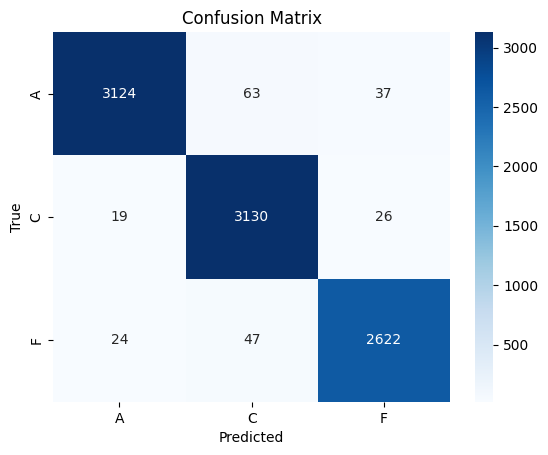

In [19]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print test performance
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoding (if necessary)
y_pred_classes = np.argmax(y_pred, axis=1)  # For classification tasks

# Generate a classification report
print(classification_report(y_test, y_pred_classes))

# Optionally, plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Assuming y_test and y_pred are your true labels and predictions
report = classification_report(y_test, y_pred_classes)
print(report)

# Save the classification report to a text file
with open('sequential_classification_report.txt', 'w') as file:
    file.write(report)

print("Classification report saved to 'sequential_classification_report.txt'")

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3224
           1       0.97      0.99      0.98      3175
           2       0.98      0.97      0.98      2693

    accuracy                           0.98      9092
   macro avg       0.98      0.98      0.98      9092
weighted avg       0.98      0.98      0.98      9092

Classification report saved to 'sequential_classification_report.txt'


In [24]:
# Assuming y_test and y_pred are your true labels and predictions
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the confusion matrix to a PDF
plt.savefig('sequential_confusion_matrix.png', format='png')

print("Confusion matrix saved to 'sequential_confusion_matrix.pdf'")

Confusion matrix saved to 'sequential_confusion_matrix.pdf'


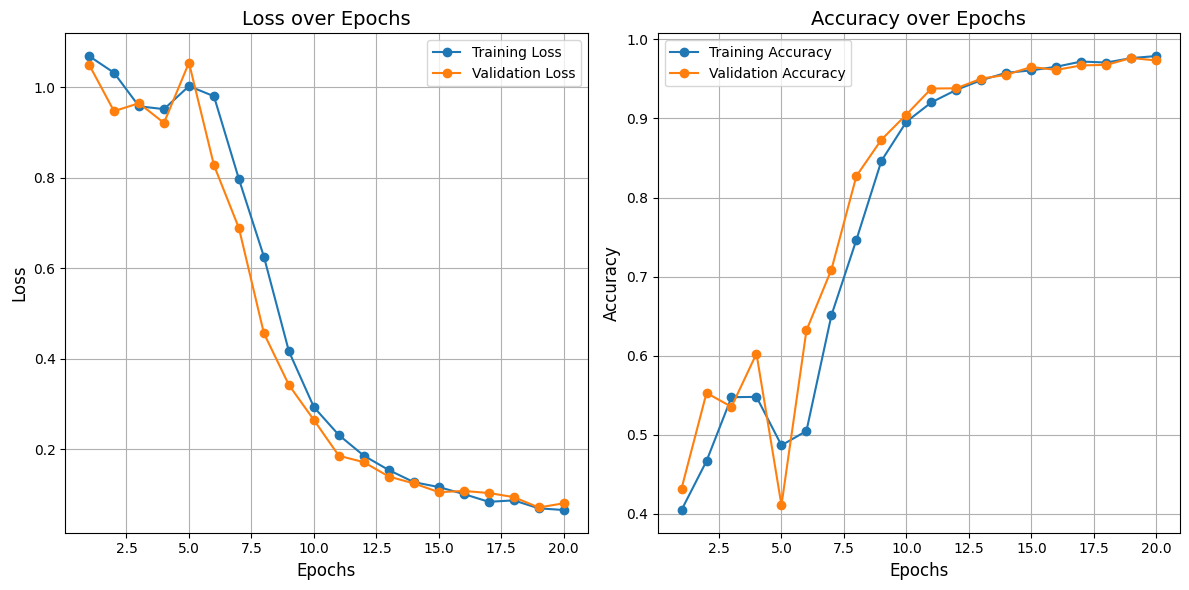

In [23]:
# Assuming `history` is the output of model.fit() containing training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # First subplot for loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)  # Second subplot for accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.savefig("training_progress.png", format="png")
plt.show()